In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from imageio.v2 import imread
import matplotlib.pyplot as plt
import os

In [8]:
train = os.listdir('../input/airbus-ship-detection/train_v2')
print("Total number of images in train dataset are {}.".format(len(train)))

test = os.listdir('../input/airbus-ship-detection/test_v2')
print("Total number of images in test dataset are {}.".format(len(test)))

Total number of images in train dataset are 192556.
Total number of images in test dataset are 15606.


In [9]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [11]:
masks = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
# masks.head()
noship_img = masks[masks.isna().any(axis=1)].reset_index(drop=True)
ship_img = masks.dropna().reset_index(drop=True)
print(f"Total number of images without any ship are {len(noship_img)}")
print(f"Total number of images with at least one ship are {len(ship_img)}")

Total number of images without any ship are 150000
Total number of images with at least one ship are 81723


In [ ]:
# extract small portion of training dataset
import pandas as pd
import os
import shutil

# Load the CSV file with RLE encoding information
df = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')

# Select a small subset of the data (e.g., 100 samples)
subset = df.sample(n=10000)

# Create a directory for the subset of images
os.mkdir('/my_shipdetection/subset_images')

# Copy the subset of images to the new directory
for index, row in subset.iterrows():
    image_path = '../input/airbus-ship-detection/train_v2/' + row['ImageId']
    subset_path = '/my_shipdetection/subset_images/' + row['ImageId']
    shutil.copy(image_path, subset_path)
    
    ## Extract the RLE information for the current image from the original DataFrame
    rle_info = df.loc[df['ImageId'] == row['ImageId'], 'EncodedPixels'].values[0]
    rle_info = str(rle_info)

    # Save the ImageId and RLE information to a new CSV file
    with open('/my_shipdetection/dataset.csv', 'a') as f:
        f.write(row['ImageId'] + ',' + rle_info + '\n')

In [ ]:
df_airbus = pd.read_csv('/ship-data/my_shipdetection/dataset.csv')
df_airbus.fillna('', inplace=True)
df_airbus.to_csv('/ship-data/dataset.csv')

In [14]:
grouped_ship_img = ship_img['EncodedPixels'] = ship_img['EncodedPixels'] + ' '
grouped_ship_img = ship_img.groupby('ImageId').agg({'EncodedPixels': 'sum'})
grouped_ship_img

EncodedPixels
ImageId                                                         
000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...
0002756f7.jpg  255784 2 256552 4 257319 7 258087 9 258854 12 ...
00031f145.jpg  340363 1 341129 4 341896 6 342663 7 343429 10 ...
...                                                          ...
fff77c602.jpg  133056 1 133823 4 134591 6 135358 8 136126 10 ...
fff909871.jpg  441057 2 441825 4 442592 7 443360 9 444128 11 ...
fffcb6464.jpg  222782 4 223550 10 224318 14 225086 14 225854 ...
fffd924fb.jpg  110011 5 110779 5 111547 5 112315 5 113083 5 1...
fffdd2377.jpg  333603 7 334359 19 335120 26 335888 26 336656 ...

[42556 rows x 1 columns]

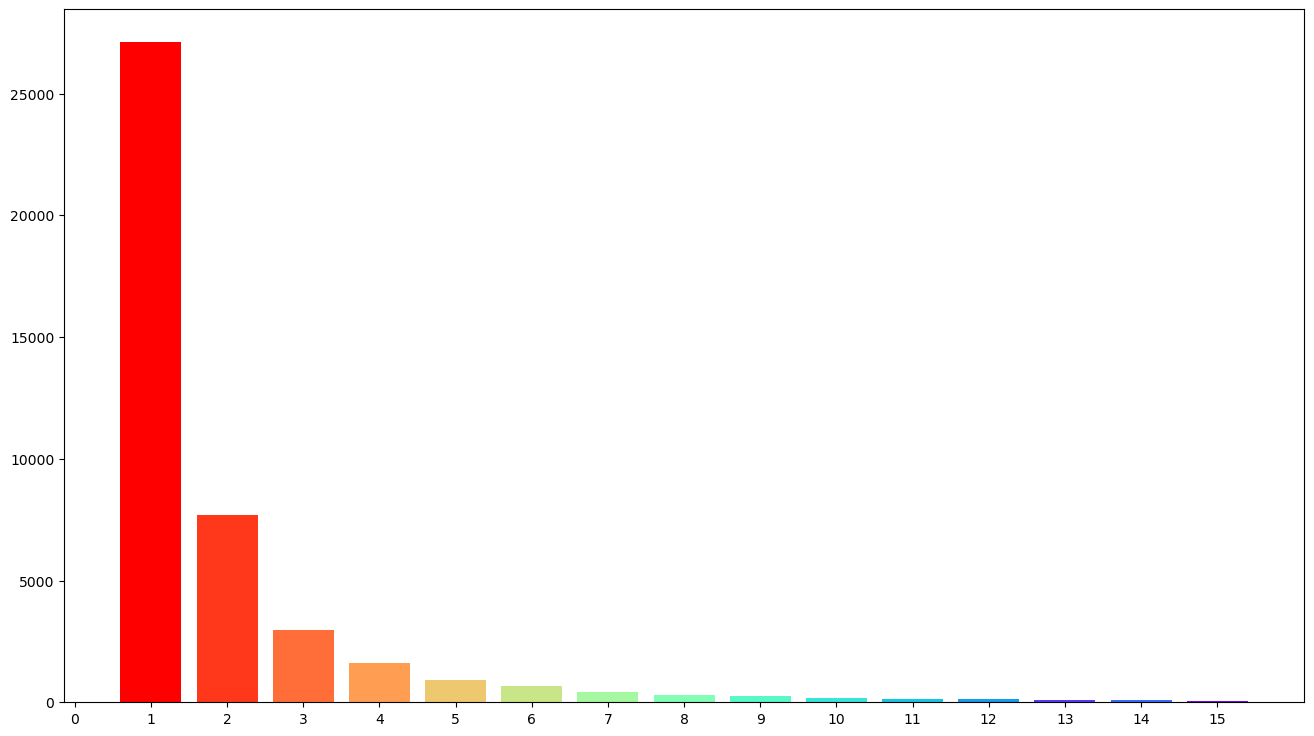

In [15]:
ship_count = pd.DataFrame({'ImageId':ship_img['ImageId'].value_counts(ascending=True).index, 'Ship_num' : ship_img['ImageId'].value_counts(ascending=True).values})
plt.figure(figsize=(16, 9))
colors = plt.cm.rainbow(np.linspace(1, 0, len(ship_count['Ship_num'].value_counts().index)))

plt.bar(ship_count['Ship_num'].value_counts().index, ship_count['Ship_num'].value_counts().values, color = colors)
plt.xticks(range(len(ship_count['Ship_num'].value_counts().index) + 1))
plt.show()

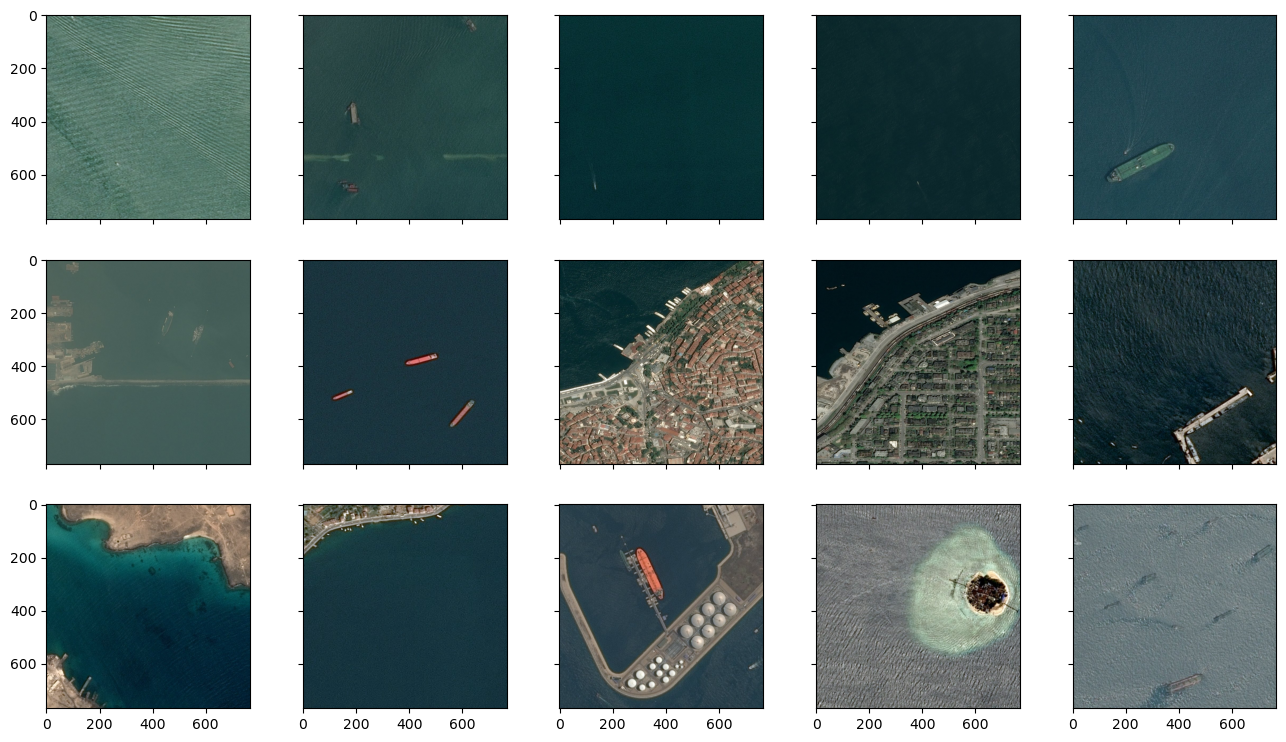

In [17]:
fig, axes = plt.subplots(3, 5, figsize=(16, 9), sharex='col', sharey='row')

np.random.seed(135)

random_imgid = np.random.choice(ship_img.ImageId, size=15)

for i, ax in enumerate(axes.flat):
    ax.imshow(imread('../input/airbus-ship-detection/train_v2/' + random_imgid[i]))

plt.show()
plt.close()

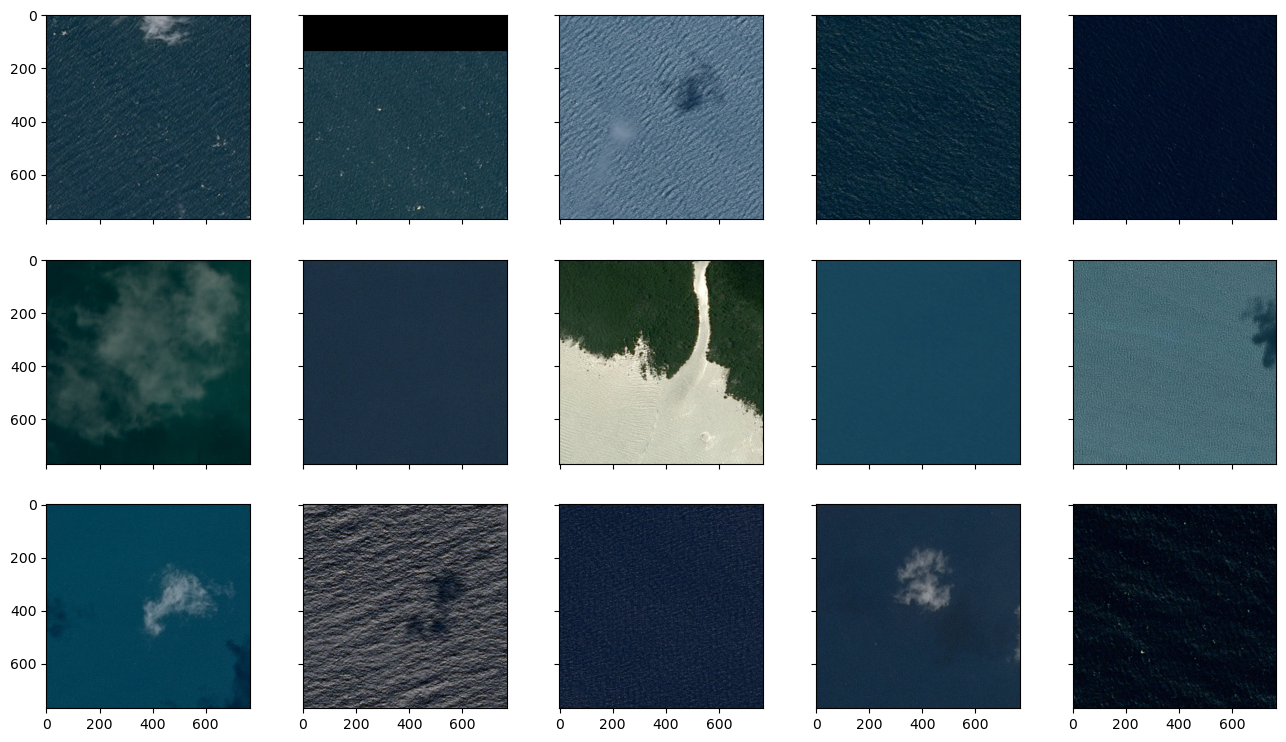

In [18]:
fig, axes = plt.subplots(3, 5, figsize=(16, 9), sharex='col', sharey='row')
np.random.seed(135)

random_imgid = np.random.choice(noship_img.ImageId, size=15)

for i, ax in enumerate(axes.flat):
    ax.imshow(imread('../input/airbus-ship-detection/train_v2/' + random_imgid[i]))

plt.show()
plt.close()

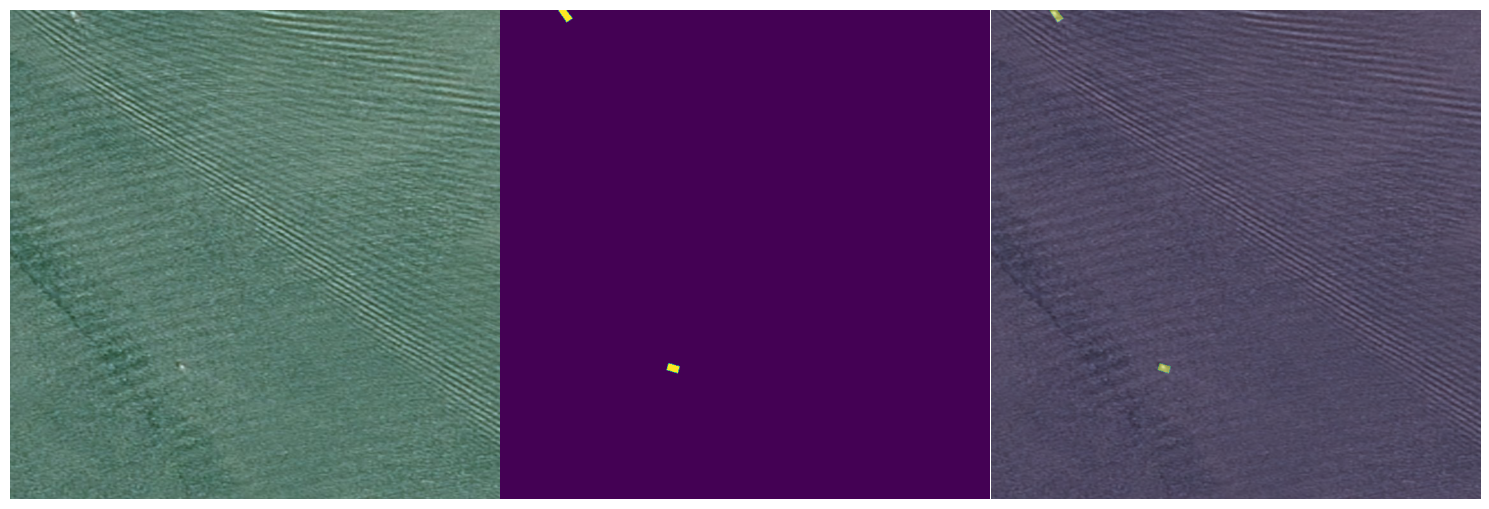

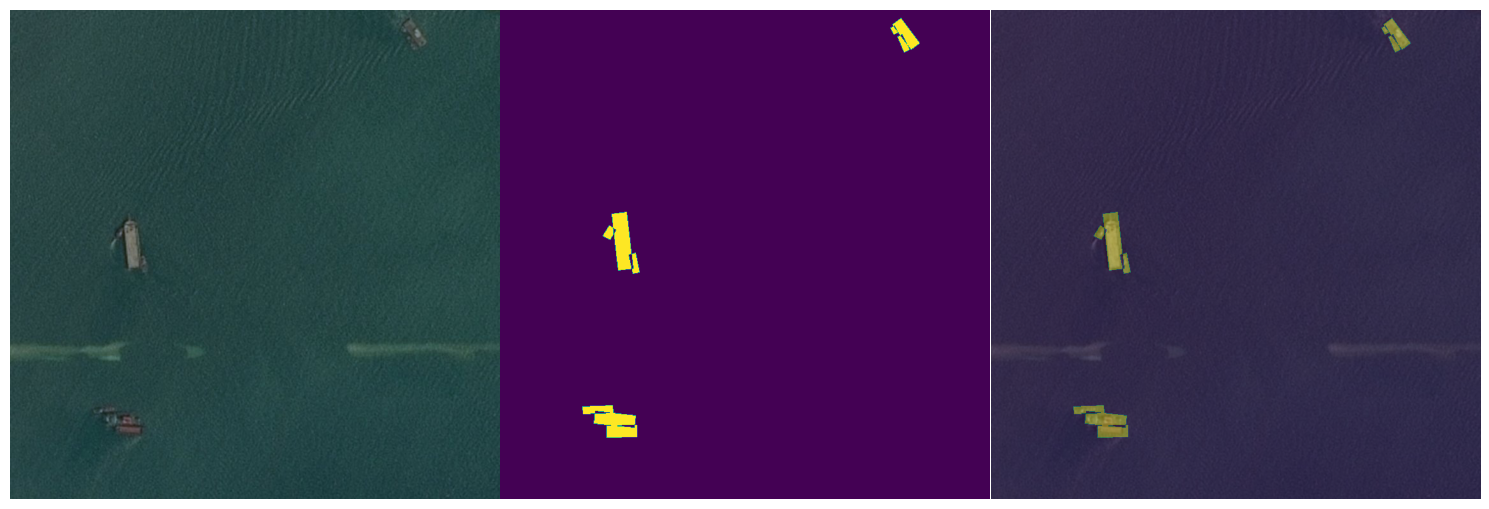

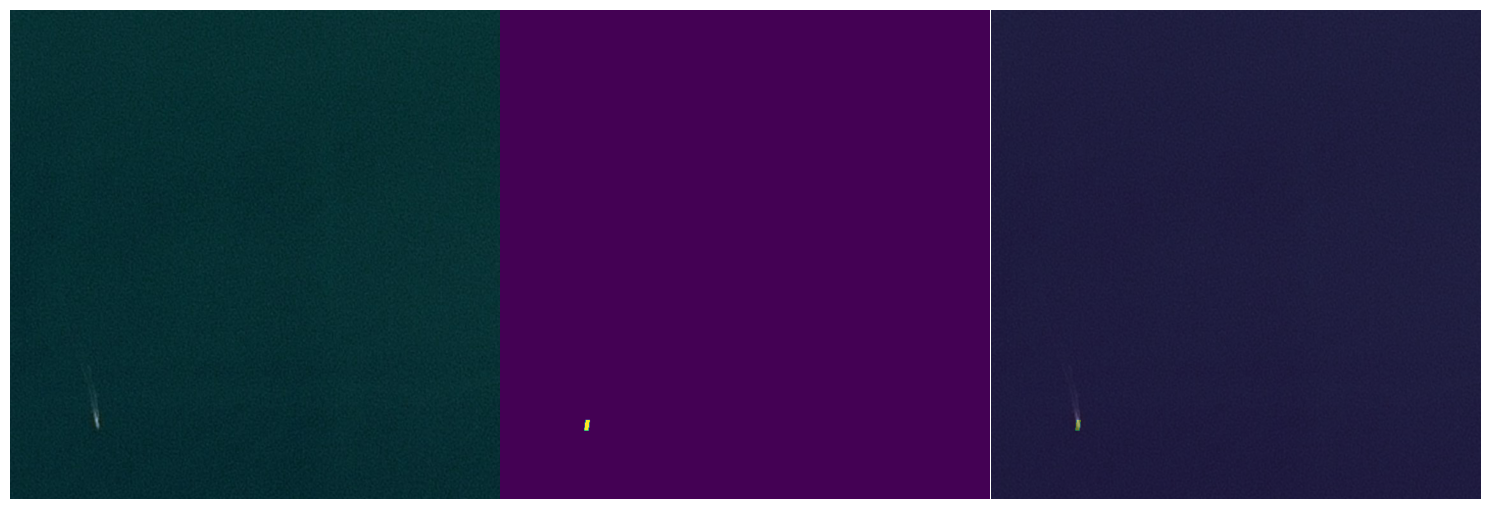

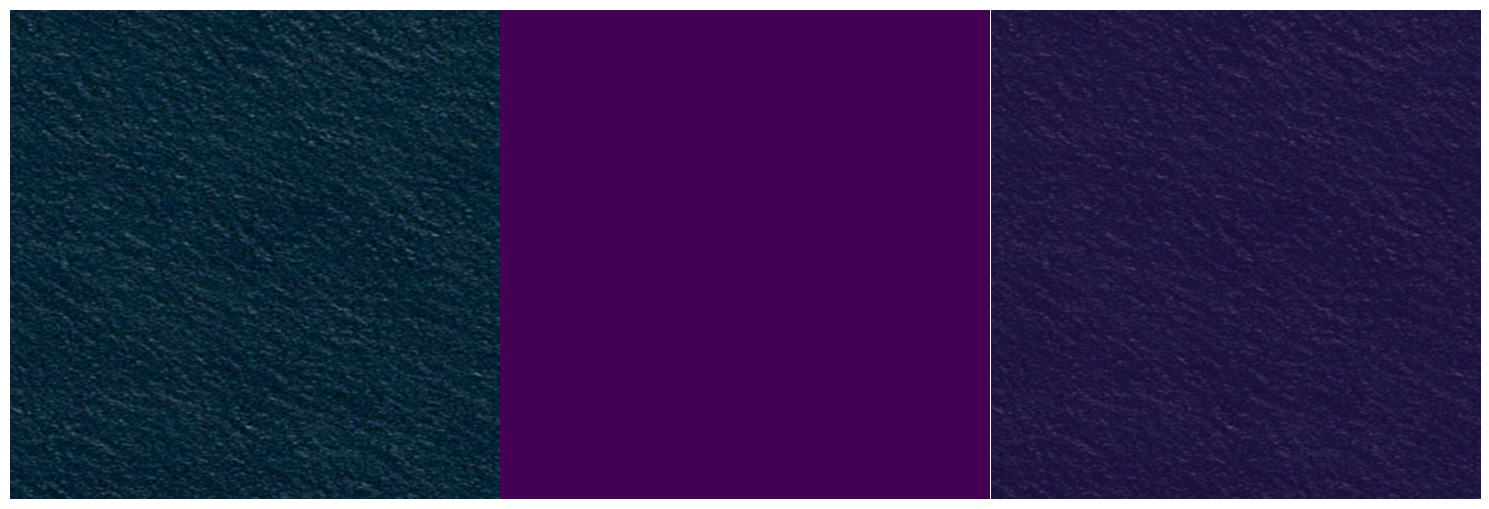

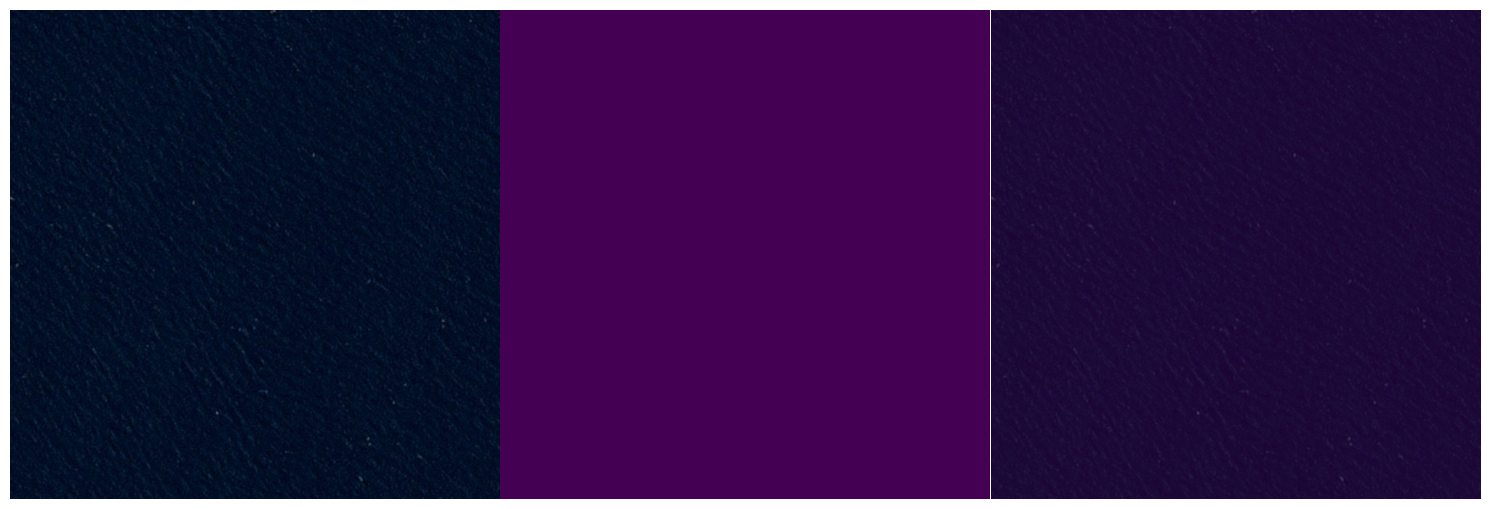

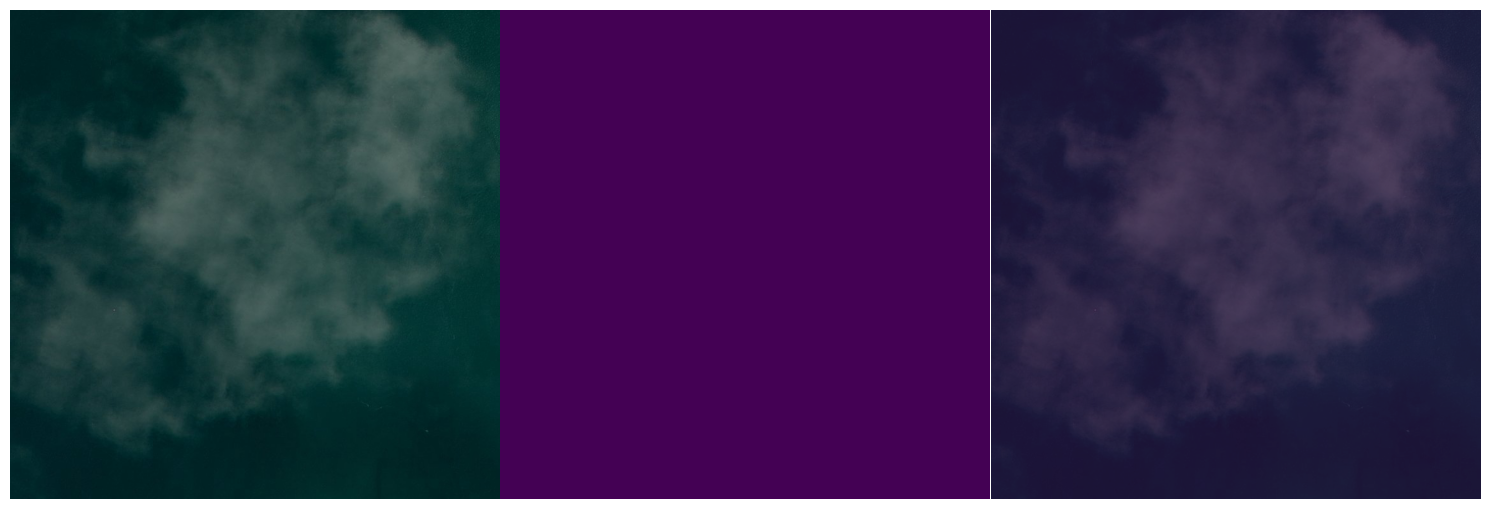

In [20]:
np.random.seed(135)

def decoding_plot(random_imgid) -> None:
    for i in range(3):
        img = imread('../input/airbus-ship-detection/train_v2/' + random_imgid[i])

        img_masks = masks.loc[masks['ImageId'] == random_imgid[i], 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        for mask in img_masks:
            # all_masks += rle_decode(mask)
            if mask==mask: 
                all_masks += rle_decode(mask)

        fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[2].axis('off')
        axarr[0].imshow(img)
        axarr[1].imshow(all_masks)
        axarr[2].imshow(img)
        axarr[2].imshow(all_masks, alpha=0.4)
        plt.tight_layout(h_pad=0.1, w_pad=0.1)
        plt.show()
        
random_imgid = np.random.choice(ship_img.ImageId, size=3)
decoding_plot(random_imgid)
random_imgid = np.random.choice(noship_img.ImageId, size=3)
decoding_plot(random_imgid)